## How to use this notebook

1. Training a QASM generator using your own dataset
  - Create a folder called "dataset" in the working directory and upload example QASM files
  - Run "Pre processing data"
  - Run " defining the Tokenizer"
  - Adjust desired hyperparameters like amount of epochs in "Defining and training the model", and then run all blocks
  - Generate using "Generate multiple realistic QASM files at once" block in "Generate qasm files and classifier training data" tab

2. Generating data using existing KetGPT model
  - Load model by running the code block "Loading the models and tokenizer" under the "Loading old models" tab. Make sure the KetGPT model and the corresponding tokenizer, that are available from https://www.kaggle.com/datasets/boranapak/ketgpt-data are in the right directory.
  - Generate using "Generate multiple realistic QASM files at once" block in "Generate qasm files and classifier training data" tab

3. Other purposes: code blocks that were used in the research process are provided, so
  - A classifier model can be loaded/trained
  - Random circuits can be generated
  - And classifier models can be used to evaluate generated data

## Pre processing data

In [ ]:
# Install prerequisites (for Colab use)

!pip install datasets
!pip install tokenizers
!pip install transformers[torch]

In [ ]:
# General imports

import os
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import torchtext.datasets as datasets
from copy import deepcopy
from datasets import Dataset, load_dataset

In [ ]:
# Read dataset that is stored in the 'dataset' folder

full_paths = []
all_lines_list = []
for dirpath, dirnames, filenames in os.walk('dataset'):
    for f in filenames:
        full_path = os.path.join(dirpath, f)
        for line in open(full_path):
            all_lines_list.append(line)

# Trim dataset
all_lines_unique_list = []
all_lines_set = set(all_lines_list)
for lines in all_lines_set:
#    if all_lines_list.count(lines) > 0: # How many times should the line be in the dataset to make it into vocabulary
        all_lines_unique_list.append(lines)

print('There are {} lines in our vocabulary'.format(len(all_lines_unique_list)))

There are 48286 lines in our vocabulary


In [ ]:
# Define some helper functions

def tokenizer_boran(vocab, qasm_file): # Simple tokenizer used in pre-processing the data
  vector = []
  for line in qasm_file:
    try:
      index = vocab.index(line)
      vector.append(index)
    except:
      vector.append(-1)
  return vector

def detokenizer_boran(vocab, vector):
  qasm_file = []
  for element in vector:
    qasm_file.append(vocab[element])

  return qasm_file

In [ ]:
# Only count files that have no unknown lines by uncommenting commented code


all_lines_unique_list_unknown = deepcopy(all_lines_unique_list)
all_lines_unique_list_unknown.append('unk')

no_unk_list = [] # List of all lines without duplicates or unknowns
counter = 0
for dirpath, dirnames, filenames in os.walk('dataset'):

  for f in filenames:
      full_path = os.path.join(dirpath, f)
      qasm_file = []
      for line in open(full_path):
        if line[0] != '/' and line[0] != '\n':
          qasm_file.append(line)
      #vector = tokenizer_boran(all_lines_unique_list_unknown,qasm_file)
      #detokenized_qasm_file = detokenizer_boran(all_lines_unique_list_unknown, vector)
      #if 'unk' not in detokenized_qasm_file:
      no_unk_list.append(qasm_file)
      counter += 1
      if not counter%100:
       print('We are now at item {} of {}'.format(counter, len(filenames)))

We are now at item 100 of 1112
We are now at item 200 of 1112
We are now at item 300 of 1112
We are now at item 400 of 1112
We are now at item 500 of 1112
We are now at item 600 of 1112
We are now at item 700 of 1112
We are now at item 800 of 1112
We are now at item 900 of 1112
We are now at item 1000 of 1112
We are now at item 1100 of 1112


In [ ]:
# Final definition of the dataset
counter = 0
with open('dataset.txt', 'w') as f:
  for line in no_unk_list:
    if len(line) < 1024:
      if counter != 0:
        f.write("\n")
      f.write("%s" % line)
      counter =+ 1

dataset = load_dataset("text", data_files = 'dataset.txt') # Dataset can be loaded like this whenever needed


with open('data.txt', 'w') as f: # Rewrite data.txt file for other purpose
  for line in all_lines_unique_list:
    if line[-1] == '\n':
      f.write("%s" % line)
    else:
      f.write("%s\n" % line)

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
len(dataset["train"])

713

## Defining the Tokenizer

In [ ]:
# Relevant imports

from tokenizers import ByteLevelBPETokenizer
from tokenizers.pre_tokenizers import CharDelimiterSplit
import json
import os
from functools import lru_cache
from typing import TYPE_CHECKING, List, Optional, Tuple
import regex as re
from transformers.tokenization_utils import AddedToken, PreTrainedTokenizer
from transformers.utils import logging
if TYPE_CHECKING:
    from transformers.pipelines.conversational import Conversation

In [ ]:
# Defining my own GPT2Tokenizer class to circumvent BPE tokenisation
# Most code is from the Huggingface implementation

logger = logging.get_logger(__name__)

VOCAB_FILES_NAMES = {
    "vocab_file": "vocab.json",
    "merges_file": "merges.txt",
}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "gpt2": "https://huggingface.co/gpt2/resolve/main/vocab.json",
        "gpt2-medium": "https://huggingface.co/gpt2-medium/resolve/main/vocab.json",
        "gpt2-large": "https://huggingface.co/gpt2-large/resolve/main/vocab.json",
        "gpt2-xl": "https://huggingface.co/gpt2-xl/resolve/main/vocab.json",
        "distilgpt2": "https://huggingface.co/distilgpt2/resolve/main/vocab.json",
    },
    "merges_file": {
        "gpt2": "https://huggingface.co/gpt2/resolve/main/merges.txt",
        "gpt2-medium": "https://huggingface.co/gpt2-medium/resolve/main/merges.txt",
        "gpt2-large": "https://huggingface.co/gpt2-large/resolve/main/merges.txt",
        "gpt2-xl": "https://huggingface.co/gpt2-xl/resolve/main/merges.txt",
        "distilgpt2": "https://huggingface.co/distilgpt2/resolve/main/merges.txt",
    },
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "gpt2": 1024,
    "gpt2-medium": 1024,
    "gpt2-large": 1024,
    "gpt2-xl": 1024,
    "distilgpt2": 1024,
}

class GPT2Tokenizer(PreTrainedTokenizer):
    """
    Construct a GPT-2 tokenizer. Based on byte-level Byte-Pair-Encoding.
    This tokenizer has been trained to treat spaces like parts of the tokens (a bit like sentencepiece) so a word will
    be encoded differently whether it is at the beginning of the sentence (without space) or not:
    ```
    >>> from transformers import GPT2Tokenizer
    >>> tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    >>> tokenizer("Hello world")['input_ids']
    [15496, 995]
    >>> tokenizer(" Hello world")['input_ids']
    [18435, 995]
    ```
    You can get around that behavior by passing `add_prefix_space=True` when instantiating this tokenizer or when you
    call it on some text, but since the model was not pretrained this way, it might yield a decrease in performance.
    <Tip>
    When used with `is_split_into_words=True`, this tokenizer will add a space before each word (even the first one).
    </Tip>
    This tokenizer inherits from [`PreTrainedTokenizer`] which contains most of the main methods. Users should refer to
    this superclass for more information regarding those methods.
    Args:
        vocab_file (`str`):
            Path to the vocabulary file.
        merges_file (`str`):
            Path to the merges file.
        errors (`str`, *optional*, defaults to `"replace"`):
            Paradigm to follow when decoding bytes to UTF-8. See
            [bytes.decode](https://docs.python.org/3/library/stdtypes.html#bytes.decode) for more information.
        unk_token (`str`, *optional*, defaults to `<|endoftext|>`):
            The unknown token. A token that is not in the vocabulary cannot be converted to an ID and is set to be this
            token instead.
        bos_token (`str`, *optional*, defaults to `<|endoftext|>`):
            The beginning of sequence token.
        eos_token (`str`, *optional*, defaults to `<|endoftext|>`):
            The end of sequence token.
        add_prefix_space (`bool`, *optional*, defaults to `False`):
            Whether or not to add an initial space to the input. This allows to treat the leading word just as any
            other word. (GPT2 tokenizer detect beginning of words by the preceding space).
    """

    vocab_files_names = VOCAB_FILES_NAMES
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES
    model_input_names = ["input_ids", "attention_mask"]

    def __init__(
        self,
        vocab_file,
        merges_file,
        errors="replace",
        unk_token="<|endoftext|>",
        bos_token="<|endoftext|>",
        eos_token="<|endoftext|>",
        pad_token=None,
        add_prefix_space=False,
        add_bos_token=False,
        **kwargs,
    ):
        bos_token = AddedToken(bos_token, lstrip=False, rstrip=False) if isinstance(bos_token, str) else bos_token
        eos_token = AddedToken(eos_token, lstrip=False, rstrip=False) if isinstance(eos_token, str) else eos_token
        unk_token = AddedToken(unk_token, lstrip=False, rstrip=False) if isinstance(unk_token, str) else unk_token
        pad_token = AddedToken(pad_token, lstrip=False, rstrip=False) if isinstance(pad_token, str) else pad_token
        super().__init__(
            errors=errors,
            unk_token=unk_token,
            bos_token=bos_token,
            eos_token=eos_token,
            pad_token=pad_token,
            add_prefix_space=add_prefix_space,
            add_bos_token=add_bos_token,
            **kwargs,
        )
        self.add_bos_token = add_bos_token

        with open(vocab_file, encoding="utf-8") as vocab_handle:
            self.encoder = json.load(vocab_handle)
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.errors = errors  # how to handle errors in decoding
        self.byte_encoder = self.encoder
        self.byte_decoder = self.decoder
        with open(merges_file, encoding="utf-8") as merges_handle:
            bpe_merges = merges_handle.read().split("\n")[1:-1]
        bpe_merges = [tuple(merge.split()) for merge in bpe_merges]
        self.bpe_ranks = dict(zip(bpe_merges, range(len(bpe_merges))))
        self.cache = {}
        self.add_prefix_space = add_prefix_space

        # Should have added re.IGNORECASE so BPE merges can happen for capitalized versions of contractions
        #self.pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")

    @property
    def vocab_size(self):
        return len(self.encoder)

    def get_vocab(self):
        return dict(self.encoder, **self.added_tokens_encoder)

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        if self.add_bos_token:
            bos_token_ids = [self.bos_token_id]
        else:
            bos_token_ids = []

        output = bos_token_ids + token_ids_0

        if token_ids_1 is None:
            return output

        return output + bos_token_ids + token_ids_1

 #   def get_special_tokens_mask(
 #       self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None, already_has_special_tokens: bool = False
 #   ) -> List[int]:
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer `prepare_for_model` or `encode_plus` methods.
        Args:
            token_ids_0 (`List[int]`):
                List of IDs.
            token_ids_1 (`List[int]`, *optional*):
                Optional second list of IDs for sequence pairs.
            already_has_special_tokens (`bool`, *optional*, defaults to `False`):
                Whether or not the token list is already formatted with special tokens for the model.
        Returns:
            `List[int]`: A list of integers in the range [0, 1]: 1 for a special token, 0 for a sequence token.
        """
 #       if already_has_special_tokens:
 #           return super().get_special_tokens_mask(
 #               token_ids_0=token_ids_0, token_ids_1=token_ids_1, already_has_special_tokens=True
 #           )

  #      if not self.add_bos_token:
   #         return super().get_special_tokens_mask(
    #            token_ids_0=token_ids_0, token_ids_1=token_ids_1, already_has_special_tokens=False
     #       )

      #  if token_ids_1 is None:
       #     return [1] + ([0] * len(token_ids_0))
        #return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1))

    def tokenize_boran(self, text):
        """Tokenize a string."""
        #bpe_tokens = []
        #for token in re.findall(self.pat, text): #This was the huggingface implementation
        #    token = "".join(
        #        self.byte_encoder[b] for b in token.encode("utf-8")
        #    )  # Maps all our bytes to unicode strings, avoiding control tokens of the BPE (spaces in our case)
        #    bpe_tokens.extend(bpe_token for bpe_token in self.bpe(token).split(" "))
        #bpe_token = self.encoder.get(text)
        #bpe_tokens.extend([bpe_token])
        bpe_tokens = text
        try:
          if text[0][0] == '[':
            bpe_tokens = []
            for subtext_index, subtext in enumerate(text):
              text_replaced = text[subtext_index].replace("'", "")
              text_replaced = text_replaced.replace("\\n", "\n")
              text_replaced = text_replaced.replace("\\t", "\t") #new
              text_replaced = text_replaced[1:]
              bpe_tokens.append(text_replaced[:-1].split(', '))

        except:
          bpe_tokens = text

        return bpe_tokens
    def tokenize(self, text, is_split_into_words = True):
      bpe_tokens = text
      return text


    def _convert_token_to_id(self, token):
        """Converts a token (str) in an id using the vocab."""
        return self.encoder.get(token, self.encoder.get(self.unk_token))

    def _convert_id_to_token(self, index):
        """Converts an index (integer) in a token (str) using the vocab."""
        return self.decoder.get(index)

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (string) in a single string."""
        text = "".join(tokens)
        text = self.byte_decoder[text]
        return text

    def convert_tokens_to_string(self, tokens: List[str]) -> str:
        return tokens

    def convert_tokens_to_ids(self, tokens):
      return self.encoder.get(tokens, self.encoder.get(self.unk_token))

    def convert_tokens_to_ids(self, tokens):
      try:
        ids = [self.encoder.get(tokens)]
        if tokens == '<pad>' or tokens == '<s>' or tokens == '</s>' or tokens == '<mask>':
          ids = self.encoder.get(tokens)
      except:
        try:
          ids = []
          for token in tokens:
            id = self.encoder.get(token)
            ids.append(id)
        except:
          ids = []
          ids_list = []
          for lists in tokens:
            for token in lists:
              id = self.encoder.get(token)
              ids.append(id)
            ids_list.append(ids)
          ids = ids_list
      return ids

    def save_vocabulary(self, save_directory: str, filename_prefix: Optional[str] = None) -> Tuple[str]:
        if not os.path.isdir(save_directory):
            logger.error(f"Vocabulary path ({save_directory}) should be a directory")
            return
        vocab_file = os.path.join(
            save_directory, (filename_prefix + "-" if filename_prefix else "") + VOCAB_FILES_NAMES["vocab_file"]
        )
        merge_file = os.path.join(
            save_directory, (filename_prefix + "-" if filename_prefix else "") + VOCAB_FILES_NAMES["merges_file"]
        )

        with open(vocab_file, "w", encoding="utf-8") as f:
            f.write(json.dumps(self.encoder, indent=2, sort_keys=True, ensure_ascii=False) + "\n")

        index = 0
        with open(merge_file, "w", encoding="utf-8") as writer:
            writer.write("#version: 0.2\n")
            for bpe_tokens, token_index in sorted(self.bpe_ranks.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        f"Saving vocabulary to {merge_file}: BPE merge indices are not consecutive."
                        " Please check that the tokenizer is not corrupted!"
                    )
                    index = token_index
                writer.write(" ".join(bpe_tokens) + "\n")
                index += 1

        return vocab_file, merge_file

    def prepare_for_tokenization(self, text, is_split_into_words=False, **kwargs):
        add_prefix_space = kwargs.pop("add_prefix_space", self.add_prefix_space)
        if is_split_into_words or add_prefix_space:
            text = text
        return (text, kwargs)

    def _build_conversation_input_ids(self, conversation: "Conversation") -> List[int]:
        input_ids = []
        for is_user, text in conversation.iter_texts():
            input_ids.extend(self.encode(text, add_special_tokens=False) + [self.eos_token_id])
        if len(input_ids) > self.model_max_length:
            input_ids = input_ids[-self.model_max_length :]
        return input_ids
    def _batch_encode_plus(self, *args, **kwargs):
      # Custom implementation of _batch_encode_plus
      result = super()._batch_encode_plus(*args, **kwargs)
      # Modify the output format
      new_ids = result["input_ids"]
      new_masks = result["attention_mask"]
      result["input_ids"] = [item for sublist in new_ids for item in sublist]
      result["attention_mask"] = [item for sublist in new_masks for item in sublist]
      if 0 == True:
        result["input_ids"] = result["input_ids"][:3]
        result["attention_mask"] = result["attention_mask"][:3]

      return result

In [ ]:
# "training" the tokenizer by creating a vocab.json file

!mkdir gpt_tokenizer # Ask Colab to create gpt_tokenizer folder

with open('data.txt') as f: # lines object is all lines of interest
    lines = f.read().splitlines()

with open('gpt_tokenizer/vocab.json', 'w') as f: # Create vocab.json
  f.write("{")
  f.write('"<s>":0,"<pad>":1,"</s>":2,"<unk>":3,"<mask>":4,"\\n":5')
  for i, line in enumerate(lines):
    if line:
      if line[0] != '\t':
        f.write(",\"{}\\n\":{}".format(line.replace('"','\\"'),i+6))
      else:
        f.write(",\"\\t{}\\n\":{}".format(line[1:].replace('"','\\"'),i+6))
  f.write("}")

open('gpt_tokenizer/merges.txt', 'w') # Create empty merges.txt


<_io.TextIOWrapper name='gpt_tokenizer/merges.txt' mode='w' encoding='UTF-8'>

In [ ]:
# Defining the tokenizer
# Minor bug: Prints a number for some reason
with open('gpt_tokenizer/vocab.json', encoding="utf-8") as vocab_handle:
        GPT2Tokenizer.encoder = json.load(vocab_handle)
tokenizer = GPT2Tokenizer.from_pretrained('gpt_tokenizer')
tokenizer.add_special_tokens({
    "eos_token": "</s>",
    "bos_token": "<s>",
    "unk_token": "<unk>",
    "pad_token": "<pad>",
    "mask_token": "<mask>"
})


0

In [ ]:
# Test to see if our tokenizer works

tokenizer(['h q[0];\n', 'h q[1];\n'])

{'input_ids': [15616, 29729], 'attention_mask': [1, 1]}

## Defining and training the model

In [ ]:
# relevant imports

from transformers import GPT2Config, GPT2LMHeadModel, DataCollatorForLanguageModeling, \
                          Trainer, TrainingArguments

In [ ]:
# Defining the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # To specify that we want to use colab GPU if it is available

config = GPT2Config(
    vocab_size = tokenizer.vocab_size + 7, # +7 is for added special tokens
    bos_token = tokenizer.bos_token_id,
    eos_token = tokenizer.eos_token_id,
    n_embd = 768, # Default
    n_layer = 4, # Default is 12, comment this line out to get a larger model
    n_head = 6, # Default is 12, comment this line out to get a larger model
    n_positions = 1024 # Default
)

model = GPT2LMHeadModel(config).to(device)

In [ ]:
# Tokenize the dataset

dataset = dataset["train"]
def tokenize_boran_per_example(text): # Function that makes the data into a list of strings where every string is a valid OPENQASM line
        bpe_tokens = text
        try:
          if text[0] == '[':
            bpe_tokens = []
            text_replaced = text.replace("'", "")
            text_replaced = text_replaced.replace("\\n", "\n")
            text_replaced = text_replaced.replace("\\t", "\t") #new
            text_replaced = text_replaced[1:]
            text_without_newline = text_replaced[:-1].split('\n, ')
            if text_without_newline[-1][-1] != '\n':
             text_without_newline[-1] = text_without_newline[-1] + '\n'
            text_replaced = [element + "\n" for element in text_without_newline[:-1]]
            text_replaced.append(text_without_newline[-1])
            bpe_tokens.append(text_replaced)


        except:
          bpe_tokens = text

        return bpe_tokens


def tokenize_within_dataset(dataset): # Function that defines the actual tokenization of the dataset
     dataset["text"] = tokenize_boran_per_example(dataset["text"])[0]
     try:
      result = tokenizer(dataset["text"], max_length = 1024, truncation = True, padding = True) # was 512
     except: # In case there is an unexpected error, the text dataset entry will be returned
      result = dataset["text"]
     return result

dataset = dataset.map(tokenize_within_dataset) # Performs the tokenisation according to the defined funcions
dataset = dataset.remove_columns("text")

# exclude datapoints from the dataset for which the tokenisation was not succesfull
exclude_idx = []
for i in range(len(dataset)):
  if None in dataset[i]["input_ids"]:
    exclude_idx.append(i)

dataset = dataset.select(
    (
        i for i in range(len(dataset))
        if i not in set(exclude_idx)
    )
)

print('Deleted {} datapoints out of the total {}'.format(len(exclude_idx), len(dataset) + len(exclude_idx)))

data_collator = DataCollatorForLanguageModeling(tokenizer = tokenizer, mlm=False)

Map:   0%|          | 0/713 [00:00<?, ? examples/s]

Parameter 'indices'=<generator object <genexpr> at 0x78424b2c1460> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Deleted 0 datapoints out of the total 713


In [ ]:
# Define training arguments and train the model

training_args = TrainingArguments(
    output_dir = "model",
    overwrite_output_dir = True,
    num_train_epochs = 5,
    per_device_train_batch_size = 4,
    save_steps = 1000,
    save_total_limit = 2,
    prediction_loss_only = False,
    remove_unused_columns = False,
#    learning_rate = 1e-5,
    logging_first_step = True
)

trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    train_dataset = dataset
    )

start_time_generator_training = time.time() #To measure the amount of time it takes to train

trainer.train()

end_time_generator_training = time.time()

elapsed_time_generator_training = end_time_generator_training - start_time_generator_training

print(f"Elapsed time: {elapsed_time_generator_training} seconds")


trainer.save_model("trained_model")

Step,Training Loss
1,10.957100
500,5.288900


Elapsed time: 258.12660932540894 seconds


## Loading old models

In [ ]:
# To make use of Google Drive inside of Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy trained generator model from drive to local session
!cp -r '/content/drive/MyDrive/trained_model_final_version' /content/

In [ ]:
# Copy tokenizer from drive to local session
!cp -r '/content/drive/MyDrive/tokenizer_final_version' /content/

In [ ]:
# Copy pickled file for KetGPT circuits from drive to local session
!cp -r '/content/drive/MyDrive/decoded_outputs_final_version_temperature_1_epochs_5.pkl' /content/

In [ ]:
# Copy pickled random file from drive to local session
!cp -r '/content/drive/MyDrive/random_circuits.pkl' /content/

In [ ]:
# Copy trained classifier model from drive to local session
!cp -r '/content/drive/MyDrive/trained_classifier_model_final_version' /content/

In [ ]:
# Copy trained classifier model from drive to local session
!cp -r '/content/drive/MyDrive/model_classification_final_6_epochs' /content/

In [ ]:
# Loading the models and tokenizer
from transformers import AutoModelForCausalLM,  AutoModelForSequenceClassification, DistilBertTokenizer
import pickle
model = AutoModelForCausalLM.from_pretrained("./trained_model_final_version").to(device)
tokenizer = GPT2Tokenizer.from_pretrained('tokenizer_final_version')
with open('/content/decoded_outputs_final_version_temperature_1_epochs_5.pkl', 'rb') as f:
    decoded_outputs = pickle.load(f)
with open('/content/random_circuits.pkl', 'rb') as f:
    list_of_naive_random_circuits = pickle.load(f)
model_classification = AutoModelForSequenceClassification.from_pretrained("./model_classification_final_6_epochs").to(device)
tokenizer_classification = DistilBertTokenizer.from_pretrained("./trained_classifier_model_final_version")


In [ ]:
# The rest of the code cells in this section after this are auxiliary and are not important

# Zips trained_model folder

import locale
locale.getpreferredencoding = lambda: "UTF-8"
#!zip -r /content/trained_model.zip /content/trained_model

In [ ]:
for index, qasm_example in enumerate(list_of_naive_random_circuits):
  print('File number {} has line {}'.format(index, qasm_example[2]))

In [ ]:
for index, qasm_example in enumerate(list_of_naive_random_circuits):
  if qasm_example[2] == 'qreg q[6];\n':
    print('File number {} has line {}'.format(index, qasm_example[2]))

In [ ]:
!zip -r /content/generated_qasm_files_without_measure_fixed.zip /content/generated_qasm_files_without_measure_fixed/

  adding: content/generated_qasm_files_without_measure_fixed/ (stored 0%)
  adding: content/generated_qasm_files_without_measure_fixed/KetGPT_194.qasm (deflated 90%)
  adding: content/generated_qasm_files_without_measure_fixed/KetGPT_576.qasm (deflated 83%)
  adding: content/generated_qasm_files_without_measure_fixed/KetGPT_788.qasm (deflated 87%)
  adding: content/generated_qasm_files_without_measure_fixed/KetGPT_929.qasm (deflated 58%)
  adding: content/generated_qasm_files_without_measure_fixed/KetGPT_698.qasm (deflated 84%)
  adding: content/generated_qasm_files_without_measure_fixed/KetGPT_980.qasm (deflated 78%)
  adding: content/generated_qasm_files_without_measure_fixed/KetGPT_870.qasm (deflated 87%)
  adding: content/generated_qasm_files_without_measure_fixed/KetGPT_977.qasm (deflated 84%)
  adding: content/generated_qasm_files_without_measure_fixed/KetGPT_307.qasm (deflated 68%)
  adding: content/generated_qasm_files_without_measure_fixed/KetGPT_873.qasm (deflated 91%)
  addi

In [ ]:
# Copy trained_model from local session to drive
!cp -r '/content/trained_model/' '/content/drive/MyDrive/trained_model_final_version'

In [ ]:
# Copy trained_classifier_model from local session to drive
!cp -r '/content/trained_classifier_model/' '/content/drive/MyDrive/trained_classifier_model_final_version'

In [ ]:
# Copy classifier tokenizer from local session to drive
!cp -r '/content/gpt_tokenizer/' '/content/drive/MyDrive/tokenizer_final_version'

In [ ]:
!cp -r '/content/decded_outputs.pkl' '/content/drive/MyDrive/decoded_outputs.pkl'

In [ ]:
# Copy tokenizer from local session to drive
!cp -r '/content/gpt_tokenizer/' '/content/drive/MyDrive/tokenizer_final_version'

In [ ]:
# Copy trained_classifier_model from local session to drive
!cp -r '/content/model_classification_final_6_epochs/' '/content/drive/MyDrive/model_classification_final_6_epochs'

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!unzip trained_model.zip

In [ ]:
tokenizer(['h q[0];\n', 'h q[1];\n'])

{'input_ids': [7998, 14072], 'attention_mask': [1, 1]}

## Generate qasm files and classifier training data

In [ ]:
# Generate new data with model
# Running this block generates one QASM file

# Define amount of qubits and starting lines

amount_of_qubits = 8

input_ids = torch.tensor(tokenizer(['OPENQASM 2.0;\n', 'include "qelib1.inc";\n', 'qreg q[{}];\n'.format(amount_of_qubits)])["input_ids"]).to(device)#tokenizer(['OPENQASM 2.0;\n', 'include "qelib1.inc";\n', 'qreg q[{}];\n'.format(amount_of_qubits)], return_tensors = "pt")["input_ids"].to('cuda')
input_ids_reshaped = torch.reshape(input_ids, (1,len(input_ids))) # To get the right shape for the generate method

# Define what part of the vocabulary must not be used (does not work with parametrized gates yet)

bad_words = []

for string_of_interest in list(tokenizer.get_vocab().keys()):
  numbers_in_string = re.findall(r'\d+',string_of_interest)
  numbers_in_string = list(map(int, numbers_in_string)) # Convert strings to numbers
  if any(i >= amount_of_qubits for i in numbers_in_string): # Check if any of the numbers are equal or larger than the allowed amount of qubits
    bad_words.append(string_of_interest)
  if 'qreg' in string_of_interest or 'OPENQASM' in string_of_interest or 'include "qelib1.inc";' in string_of_interest:
    bad_words.append(string_of_interest)
bad_words_ids = []

for bad_word in bad_words:
  bad_words_ids.append(tokenizer.encode(bad_word))

# Generate using beam search

beam_output = model.generate(input_ids = input_ids_reshaped,
                      max_length = 250,
                      num_beams = 10,
                      no_repeat_ngram_size = 5,
                      num_return_sequences = 1,
                      bad_words_ids = bad_words_ids[:-1] # BUG? Why is -1 here?
                      )

beam_output_list = beam_output[0].tolist()
decoded_output = []
for id in beam_output_list:
  decoded_output.append(tokenizer.decoder.get(id))

print(decoded_output)
print(len(decoded_output))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['OPENQASM 2.0;\n', 'include "qelib1.inc";\n', 'qreg q[8];\n', 'creg meas[5];\n', 'h q[0];\n', 'h q[1];\n', 'cz q[0],q[1];\n', 'h q[2];\n', 'h q[3];\n', 'cz q[2],q[3];\n', 'h q[4];\n', 'h q[5];\n', 'cz q[4],q[5];\n', 'h q[6];\n', 'h q[7];\n', 'h q[7];\n', 'cz q[6],q[7];\n', 'cz q[6],q[7];\n', 'h q[6];\n', 'h q[7];\n', 'measure q[0] -> meas[0];\n', 'measure q[1] -> meas[1];\n', 'measure q[2] -> meas[2];\n', 'measure q[3] -> meas[3];\n', 'measure q[4] -> meas[4];\n', 'measure q[5] -> meas[5];\n', 'measure q[6] -> meas[6];\n', 'measure q[7] -> meas[7];\n', 'measure q[0] -> meas[0];\n', 'measure q[1] -> meas[1];\n', 'measure q[2] -> meas[2];\n', 'measure q[3] -> meas[3];\n', 'cp(pi/2) q[7],q[6];\n', 'h q[6];\n', 'measure q[0] -> c[0];\n', 'measure q[1] -> c[1];\n', 'measure q[2] -> c[2];\n', 'measure q[3] -> c[3];\n', 'measure q[4] -> c[4];\n', 'measure q[5] -> c[5];\n', 'measure q[6] -> c[6];\n', 'measure q[7] -> c[7];\n', 'cx q[6],q[7];\n', 'cx q[5],q[6];\n', 'cx q[4],q[5];\n', 'cx q[3],

In [ ]:
# Write the most likely output into a .qasm file

with open('generated_qasm_file.qasm', 'w') as f:
  for line in decoded_output:
    f.write("%s\n" % line)

In [ ]:
# Create random ciruits
# Possible problem: tokens without a gate (like comments) don't have a number in them, therefore they are more likely to be picked in case of qreg q[2] for example
# Possible problem: qubit number distribution is rough estimate since not every dataset file has qreg [

import json
import random
import numpy as np

# Create vocab of words to choose from
with open('gpt_tokenizer/vocab.json') as json_file:
  vocab = json.load(json_file)

# Create a list that gives length distribution and a list that gives an estimate of qubit number distribution in dataset
qreg_list = []
lengths_list = []
for index, qasm_of_interest in enumerate(no_unk_list):
  lengths_list.append(len(qasm_of_interest))
  if 'qreg' in qasm_of_interest[2]:
    qreg_list.append(qasm_of_interest[2])
  else:
    qreg_counter = 0
    for entry_of_interest in qasm_of_interest:
      if 'qreg [' in entry_of_interest:
        qreg_list.append(entry_of_interest)

print('We found {} entries with a recognised qreg out of the total {}. \n If that number is too low to be representatitive, there is a problem'.format(len(qreg_list), len(no_unk_list)))

# Function to create one fully random circuit
def generate_naive_random_circuit(amount_of_qubits, amount_of_gates):
  possible_gates = []

  for string_of_interest in vocab:
    numbers_in_string = re.findall(r'\d+',string_of_interest)
    numbers_in_string = list(map(int, numbers_in_string)) # Convert strings to numbers
    if 'qreg' not in string_of_interest and 'OPENQASM' not in string_of_interest and 'include "qelib1.inc";' not in string_of_interest and '<s>' not in string_of_interest and '<pad>' not in string_of_interest and '</s>' not in string_of_interest and '<unk>' not in string_of_interest and '<mask>' not in string_of_interest:
      if all(i < amount_of_qubits for i in numbers_in_string): # Check if any of the numbers are equal or larger than the allowed amount of qubits
        possible_gates.append(string_of_interest)
  random_circuit = ['OPENQASM 2.0;\n', 'include "qelib1.inc";\n', 'qreg q[{}];\n'.format(amount_of_qubits)]
  random_circuit = random_circuit + random.choices(possible_gates, k = amount_of_gates)

  return random_circuit

# Function to create a list of fully random circuits
def generate_list_of_naive_random_circuits(amount_of_circuits, set_amount_of_qubits = 'random', set_amount_of_gates = 'random'):
  list_of_naive_random_circuit_arrays = []
  list_of_naive_random_circuits = []
  updates = 0 # For counting
  for i in range(amount_of_circuits):
    if set_amount_of_qubits == 'random':
      qreg_string = random.choice(qreg_list)
      amount_of_qubits = int(re.findall(r'\d+',qreg_string)[0])
    else:
      amount_of_qubits = set_amount_of_qubits

    if set_amount_of_gates == 'random':
      amount_of_gates = int(random.choice(lengths_list))
    else:
      amount_of_gates = set_amount_of_gates

    random_circuit = generate_naive_random_circuit(amount_of_qubits,amount_of_gates - 3) #First 3 gates are predetermined
    naive_random_circuit_array = np.reshape(tokenizer(random_circuit)["input_ids"], (len(random_circuit)))
    list_of_naive_random_circuit_arrays.append(naive_random_circuit_array)
    list_of_naive_random_circuits.append(random_circuit)
    counter = round(100*i/amount_of_circuits)
    if divmod(counter, 10) == (updates,0): #To print progress every 10%
      print('We have now generated {} circuits out of {}'.format(i + 1, amount_of_circuits))
      updates += 1
  return list_of_naive_random_circuit_arrays, list_of_naive_random_circuits


# Call function to generate random data. Amount of gates and qubit number are randomly chosen from dataset
# distribution by default but can also be manually specified
list_of_naive_random_circuit_arrays, list_of_naive_random_circuits= generate_list_of_naive_random_circuits(len(no_unk_list))

We found 1112 entries with a recognised qreg out of the total 1112. 
 If that number is too low to be representatitive, there is a problem
We have now generated 1 circuits out of 1112
We have now generated 107 circuits out of 1112
We have now generated 218 circuits out of 1112
We have now generated 330 circuits out of 1112
We have now generated 441 circuits out of 1112
We have now generated 552 circuits out of 1112
We have now generated 663 circuits out of 1112
We have now generated 774 circuits out of 1112
We have now generated 886 circuits out of 1112
We have now generated 997 circuits out of 1112
We have now generated 1108 circuits out of 1112


In [ ]:
# Generate multiple realistic QASM files at once

import random
import numpy as np

amount_of_QASM_files = 1000

!mkdir generated_files # Ask Colab to create generated_files folder

decoded_outputs = []

set_amount_of_qubits = 'random' # Set the amount of qubits, the "random" option randomizes the qubit count according to the dataset distribution
set_amount_of_gates = 'random' # Set the total amount of QASM statements, the "random" option randomizes the gate depth according to the dataset distribution

updates = 0 # Variable that is used in printing updates


if set_amount_of_qubits == 'random' or set_amount_of_gates == 'random':
  # Create a list that gives length distribution and a list that gives an estimate of qubit number distribution in dataset
  qreg_list = []
  lengths_list = []
  for index, qasm_of_interest in enumerate(no_unk_list):
    lengths_list.append(len(qasm_of_interest))
    if 'qreg' in qasm_of_interest[2]:
      qreg_list.append(qasm_of_interest[2])
    else:
      qreg_counter = 0
      for entry_of_interest in qasm_of_interest:
        if 'qreg [' in entry_of_interest:
          qreg_list.append(entry_of_interest)

  print('We found {} entries with a recognised qreg out of the total {}. \n If that number is too low to be representatitive, there is a problem'.format(len(qreg_list), len(no_unk_list)))


start_time_generator_generating = time.time() #To measure the amount of time it takes to train

time_per_file_list = []

for i in range(amount_of_QASM_files):
    start_time_per_file = time.time()

    if set_amount_of_qubits == 'random':
      qreg_string = random.choice(qreg_list)
      amount_of_qubits = int(re.findall(r'\d+',qreg_string)[0])
    else:
      amount_of_qubits = set_amount_of_qubits

    if set_amount_of_gates == 'random':
      amount_of_gates = int(random.choice(lengths_list))
      if amount_of_gates>1023:
        amount_of_gates = int(1023)
    else:
      amount_of_gates = set_amount_of_gates
    # Define what part of the vocabulary must not be used (does not work with parametrized gates yet)

    bad_words = []

    for string_of_interest in list(tokenizer.get_vocab().keys()):
      numbers_in_string = re.findall(r'\d+',string_of_interest)
      numbers_in_string = list(map(int, numbers_in_string)) # Convert strings to numbers
      if any(i >= amount_of_qubits for i in numbers_in_string): # Check if any of the numbers are equal or larger than the allowed amount of qubits, also gets rid of arbitrary rotations. To be improved!
        bad_words.append(string_of_interest)
      if 'qreg' in string_of_interest or 'OPENQASM' in string_of_interest or 'include "qelib1.inc";' in string_of_interest:
        bad_words.append(string_of_interest)
    bad_words_ids = []

    for bad_word in bad_words:
      bad_words_ids.append(tokenizer.encode(bad_word))

    input_ids = torch.tensor(tokenizer(['OPENQASM 2.0;\n', 'include "qelib1.inc";\n', 'qreg q[{}];\n'.format(amount_of_qubits)])["input_ids"]).to(device)#tokenizer(['OPENQASM 2.0;\n', 'include "qelib1.inc";\n', 'qreg q[{}];\n'.format(amount_of_qubits)], return_tensors = "pt")["input_ids"].to('cuda')
    input_ids_reshaped = torch.reshape(input_ids, (1,len(input_ids)))
    beam_output = model.generate(input_ids = input_ids_reshaped,
                          max_length = amount_of_gates,
                          #penalty_alpha=0.6,
                          do_sample = True,
                          top_k=5,
                          #num_beams = 20,
                          no_repeat_ngram_size = 15,
                          num_return_sequences = 1,
                          bad_words_ids = bad_words_ids[:-1],
                          #pad_token_id=tokenizer.eos_token_id,
                          temperature = 1.0
                          )

    beam_output_list = beam_output[0].tolist()
    decoded_output = []
    for id in beam_output_list:
      decoded_output.append(tokenizer.decoder.get(id))
    decoded_outputs.append(decoded_output)
    counter = round(100*i/amount_of_QASM_files)
    if divmod(counter, 10) == (updates,0): #To print progress every 10%
      print('We have now generated {} qasm files out of {}'.format(i + 1, amount_of_QASM_files))
      updates += 1

    end_time_per_file = time.time()

    elapsed_time_per_file = end_time_per_file - start_time_per_file

    time_per_file_list.append(elapsed_time_per_file)

end_time_generator_generating = time.time()

elapsed_time_generator_generating = end_time_generator_generating - start_time_generator_generating

print(f"Elapsed time: {elapsed_time_generator_generating} seconds")

We found 1112 entries with a recognised qreg out of the total 1112. 
 If that number is too low to be representatitive, there is a problem


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


We have now generated 1 qasm files out of 1000


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

We have now generated 96 qasm files out of 1000


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

We have now generated 196 qasm files out of 1000


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

We have now generated 296 qasm files out of 1000


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

We have now generated 396 qasm files out of 1000


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

We have now generated 496 qasm files out of 1000


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

We have now generated 596 qasm files out of 1000


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

We have now generated 696 qasm files out of 1000


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

We have now generated 796 qasm files out of 1000


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

We have now generated 896 qasm files out of 1000


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

We have now generated 996 qasm files out of 1000


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

Elapsed time: 7608.971309423447 seconds


In [ ]:
# Save generated files

import pickle
with open('/content/drive/MyDrive/decoded_outputs_hyperparameter_tuning_temperature_1_epochs_5_nlayer5_nhead_6.pkl', 'wb') as f:
    pickle.dump(decoded_outputs, f)
with open('/content/drive/MyDrive/time_list_hyperparameter_tuning_temperature_1_epochs_5_nlayer5_nhead_6.pkl', 'wb') as f:
    pickle.dump(time_per_file_list, f)

Text(0, 0.5, 'Time in seconds')

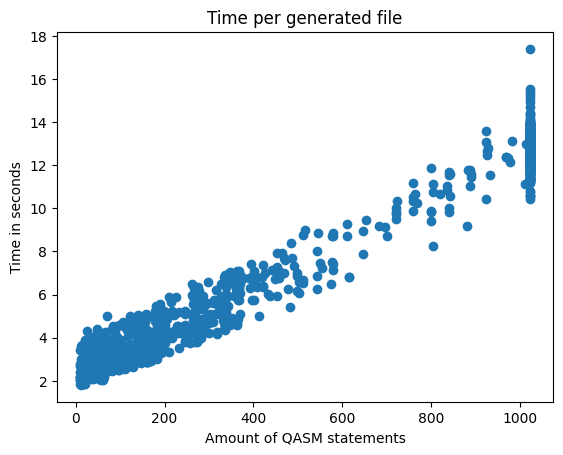

In [ ]:
# Create histogram of time that was needed to generate files

import matplotlib.pyplot as plt

used_lengths_list = []

for i in range(len(decoded_outputs)):
  used_lengths_list.append(len(decoded_outputs[i]))

plt.scatter(used_lengths_list, time_per_file_list)
plt.title('Time per generated file')
plt.xlabel('Amount of QASM statements')
plt.ylabel('Time in seconds')

In [ ]:
# Optionally load files

with open('/content/decoded_outputs_temperature_1_epochs_5.pkl', 'rb') as f:
    decoded_outputs = pickle.load(f)

In [ ]:
# Save random cicruits

import pickle
with open('/content/drive/MyDrive/random_circuits.pkl', 'wb') as f:
    pickle.dump(list_of_naive_random_circuits, f)

In [ ]:
with open('/content/random_circuits.pkl', 'rb') as f:
    list_of_naive_random_circuits = pickle.load(f)

## Creating a classifier

In [ ]:
# Delete all measure operations to ensure the classifier does not overfit

list_of_naive_random_circuits_no_measure = [[item for item in sublist if not item.startswith('m')] for sublist in list_of_naive_random_circuits]
no_unk_list_no_measure = [[item for item in sublist if not item.startswith('m')] for sublist in no_unk_list]
decoded_outputs_no_measure = [[item for item in sublist if not item.startswith('m')] for sublist in decoded_outputs]

In [ ]:
# Generate dataset and define model
from datasets import load_dataset,Dataset,DatasetDict
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput
import csv

header = ['text', 'labels']

data_true = [[no_unk_list_no_measure[i], int(0)] for i in range(round(len(no_unk_list_no_measure)))]
data_false = [[list_of_naive_random_circuits_no_measure[i], int(1)] for i in range(round(len(no_unk_list_no_measure)))]

data = data_true + data_false


with open('classification_data.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write multiple rows
    writer.writerows(data)

In [ ]:
# Prepare dataset to be fed to the model
# Load_data
dataset_classification = load_dataset('csv', data_files  = "classification_data.csv")
dataset_classification = dataset_classification["train"]


# For some datasets this code can detect if the data tokenisation was not succesful


# Exclude datapoints from the dataset for which the tokenisation was not succesfull
#exclude_idx = []
#for i in range(len(dataset_classification)):
#  if None in tokenizer(tokenize_boran_per_example(dataset_classification[i]["text"])[0])["input_ids"]:
#    exclude_idx.append(i)

#dataset_classification = dataset_classification.select(
#    (
#        i for i in range(len(dataset_classification))
#        if i not in set(exclude_idx)
#    )
#)

#print('Deleted {} datapoints out of the total {}'.format(len(exclude_idx), len(dataset_classification) + len(exclude_idx)))


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# Load distilbert tokenizer from Huggingface, do not run if you do not plan to train a new model
from transformers import AutoTokenizer

tokenizer_classification = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
# Creating a new tokenizer, do not run if you do not plan to train a new model

from tokenizers import BertWordPieceTokenizer
from transformers import DistilBertTokenizer

# Initialize a tokenizer
tokenizer_classification = BertWordPieceTokenizer()

# Train the tokenizer on your file
tokenizer_classification.train(files=["dataset.txt"], vocab_size=30522, min_frequency=0,
                special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"],
                limit_alphabet=1000, wordpieces_prefix="##")

# Save the tokenizer
tokenizer_classification.save_model(".", "/distilbert-base-uncased-retrained")


# Load the tokenizer
tokenizer_classification = DistilBertTokenizer("/distilbert-base-uncased-retrained-vocab.txt", do_lower_case=True)

In [ ]:
# Tokenize the dataset
from transformers import DataCollatorWithPadding

def preprocess_function(examples):
    return tokenizer_classification(examples["text"], truncation=True, padding = True, max_length = 512)

tokenized_dataset_distillbert = dataset_classification.map(preprocess_function, batched=False)# BUG: batched = TRUE does not work

tokenized_dataset_distillbert = tokenized_dataset_distillbert.class_encode_column("labels")
# Split dataset into test and train subdatasets
tokenized_dataset_distillbert = tokenized_dataset_distillbert.train_test_split(test_size = 0.15, stratify_by_column = "labels")

data_collator_classification = DataCollatorWithPadding(tokenizer=tokenizer_classification)

Map:   0%|          | 0/2224 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/2224 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2224 [00:00<?, ? examples/s]

In [ ]:
# Load the distilbert model we use for classification (at this point still untrained for our task), do not run if you do not plan to train a new model
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model_classification = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train the classification model

training_args_classification = TrainingArguments(
    output_dir="classification_model",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=6,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_steps = 100
)

trainer_classification = Trainer(
    model=model_classification,
    args=training_args_classification,
    train_dataset=tokenized_dataset_distillbert["train"],
    tokenizer=tokenizer_classification,
    data_collator=data_collator_classification,
)

start_time_classifier_training = time.time() #To measure the amount of time it takes to train

trainer_classification.train()

end_time_classifier_training = time.time()

elapsed_time_classifier_training = end_time_classifier_training - start_time_classifier_training

print(f"Elapsed time: {elapsed_time_classifier_training} seconds")

Step,Training Loss
100,0.700000
200,0.697900
300,0.700400
400,0.698300
500,0.699700
600,0.701600
700,0.701700
800,0.637200
900,0.614200
1000,0.320800


Elapsed time: 673.0708270072937 seconds


In [ ]:
# Predict on the test dataset and show confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

predictions = trainer_classification.predict(test_dataset = tokenized_dataset_distillbert["test"])
logits = predictions[0]
labels = predictions[1]

y_pred = []
y_true = []

for i in range(len(tokenized_dataset_distillbert["test"])):
  y_pred.append(int(np.argmax(logits[i])))
  y_true.append(int(labels[i]))

print(confusion_matrix(y_true,y_pred))

accuracy = round(accuracy_score(y_true,y_pred)*100, ndigits = 2)
print('The accuracy on the test dataset is {}%, estimated from a test dataset of size {}'.format(accuracy, len(y_true)))

[[162   5]
 [  1 166]]
The accuracy on the test dataset is 98.2%, estimated from a test dataset of size 334


In [ ]:
# Make Transformer generated circuits into csv file
import numpy as np
import csv

header_transformer = ['text']


data_transformer = np.reshape(decoded_outputs_no_measure, (len(decoded_outputs_no_measure), 1))

with open('transformer_classification_data.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header_transformer)

    # write multiple rows
    writer.writerows(data_transformer)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [ ]:
# Define dataset

dataset_classification_transformer = load_dataset('csv', data_files  = "transformer_classification_data.csv")
dataset_classification_transformer = dataset_classification_transformer["train"]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# Tokenize dataset

def preprocess_function(examples):
    return tokenizer_classification(examples["text"], truncation=True, max_length = 512)

tokenized_dataset_transformer = dataset_classification_transformer.map(preprocess_function, batched=False)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Use classifier to predict whether the Transformer generated circuits are realistic

predictions_transformer = trainer_classification.predict(test_dataset = tokenized_dataset_transformer)
predicted_labels = []

for i in range(len(predictions_transformer[0])):
  predicted_labels.append(int(np.argmax(predictions_transformer[0][i])))

amount_predicted = len(predicted_labels)
amount_real = amount_predicted - np.sum(predicted_labels) # Total amount - False amount
percentage_correct = round(100*amount_real/amount_predicted,1)
print('{} out of a total of {} circuits were identified as real, which is {}%'.format(amount_real, amount_predicted, percentage_correct))

999 out of a total of 1000 circuits were identified as real, which is 99.9%


In [ ]:
# Optional: save classification model

model_classification.save_pretrained('model_classification_final_6_epochs')

In [ ]:
# Plot histogram of predicted probabilities for Transformer data

from scipy.special import softmax

probabilities = softmax(predictions_transformer[0], axis=1)
probability_list_test = [p[0] for p in probabilities]

import numpy as np
import matplotlib.pyplot as plt

leave_out_last_bin = False

# Creating custom bins
bins = np.linspace(0, 1, 51)  # Creates 50 bins between 0 and 1
if leave_out_last_bin:
  bins = bins[:-1]
plt.hist(probability_list_test, bins=bins, alpha=0.5, label='Probability to be real') # Excluding the last bin
plt.xlim([-0.01, 1.01])
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Predicted Probabilities')
plt.show()


In [ ]:
# Plot histogram of predicted probabilities for test data

from scipy.special import softmax

probabilities = softmax(predictions[0], axis=1)
probability_list_test = [p[0] for p in probabilities]

import numpy as np
import matplotlib.pyplot as plt

leave_out_last_bin = False

# Creating custom bins
bins = np.linspace(0, 1, 51)  # Creates 50 bins between 0 and 1
if leave_out_last_bin:
  bins = bins[:-1]
plt.hist(probability_list_test, bins=bins, alpha=0.5, label='Probability to be real') # Excluding the last bin
plt.xlim([-0.01, 1.01])
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Predicted Probabilities')
plt.show()


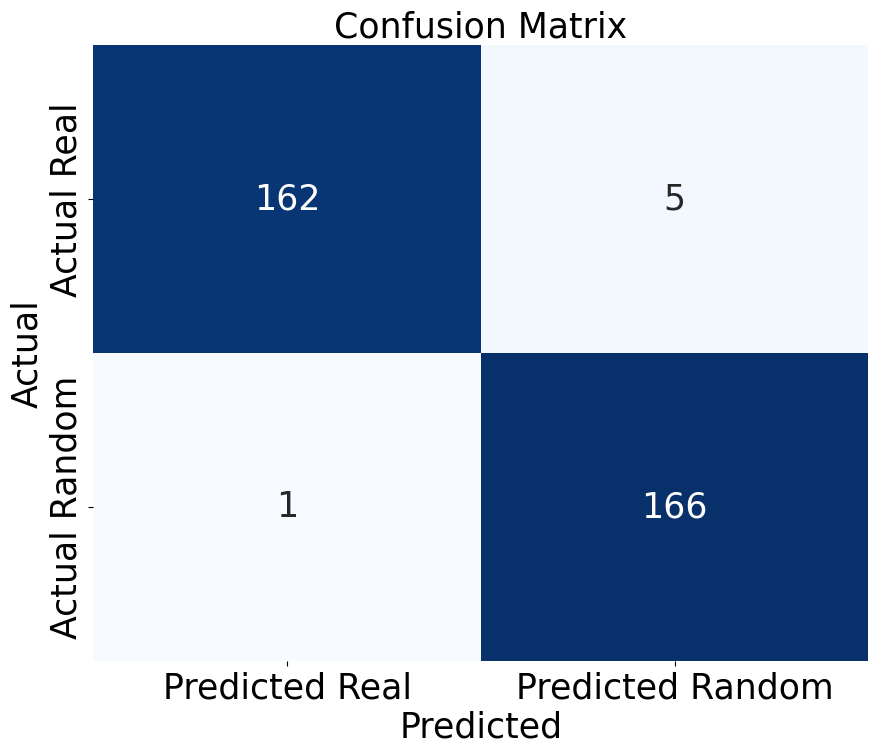

In [ ]:
# Create confusion matrix for test data

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_true,y_pred)

def scale_text(fig_width, fig_height, base_size=10):
    """Scale text based on figure dimensions."""
    scale_factor = min(fig_width/8.0, fig_height/6.0)
    return base_size * scale_factor

# Define figure size
fig_width, fig_height = 10, 8

# Calculate text sizes
annot_text_size = scale_text(fig_width, fig_height, base_size=20)
tick_label_size = scale_text(fig_width, fig_height, base_size=20)
label_text_size = scale_text(fig_width, fig_height, base_size=20)
title_text_size = scale_text(fig_width, fig_height, base_size=20)

# Create figure
plt.figure(figsize=(fig_width, fig_height))

# Create heatmap
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g',
            annot_kws={"size": annot_text_size}, cbar=False)

# Set the label text size
plt.ylabel('Actual', fontsize=label_text_size)
plt.xlabel('Predicted', fontsize=label_text_size)

# Set the title text size
plt.title('Confusion Matrix', fontsize=title_text_size)

# Set the tick label size and labels
plt.xticks(np.arange(confusion.shape[1]) + 0.5, labels=['Predicted Real', 'Predicted Random'], fontsize=tick_label_size)
plt.yticks(np.arange(confusion.shape[0]) + 0.5, labels=['Actual Real', 'Actual Random'], fontsize=tick_label_size, va="center")

plt.show()

In [ ]:
# Diagnose false predictions on test data

for i in range(len(y_true)):
  if y_true[i] != y_pred[i]:
    print(i)

68
117
188
189
196
269


In [ ]:
# Print test data that was incorrectly classified

print(tokenizer_classification.decode(tokenized_dataset_distillbert["test"][68]["input_ids"]))
print(tokenized_dataset_distillbert["test"][68]["labels"])
print(tokenizer_classification.decode(tokenized_dataset_distillbert["test"][117]["input_ids"]))
print((tokenized_dataset_distillbert["test"][117]["labels"]))
print(tokenizer_classification.decode(tokenized_dataset_distillbert["test"][188]["input_ids"]))
print((tokenized_dataset_distillbert["test"][188]["labels"]))
print(tokenizer_classification.decode(tokenized_dataset_distillbert["test"][189]["input_ids"]))
print((tokenized_dataset_distillbert["test"][189]["labels"]))
print(tokenizer_classification.decode(tokenized_dataset_distillbert["test"][196]["input_ids"]))
print((tokenized_dataset_distillbert["test"][196]["labels"]))
print(tokenizer_classification.decode(tokenized_dataset_distillbert["test"][269]["input_ids"]))
print((tokenized_dataset_distillbert["test"][269]["labels"]))

[CLS] ['openqasm 2. 0 ; \ n ','include " qelib1. inc " ; \ n ','qreg node [ 11 ] ; \ n ','qreg coin [ 1 ] ; \ n ','creg meas [ 12 ] ; \ n ','h node [ 0 ] ; \ n ','cu1 ( pi / 1024 ) node [ 10 ], node [ 0 ] ; \ n ','cx node [ 10 ], node [ 9 ] ; \ n ','cu1 ( - pi / 1024 ) node [ 9 ], node [ 0 ] ; \ n ','cx node [ 10 ], node [ 9 ] ; \ n ','cu1 ( pi / 1024 ) node [ 9 ], node [ 0 ] ; \ n ','cx node [ 9 ], node [ 8 ] ; \ n ','cu1 ( - pi / 1024 ) node [ 8 ], node [ 0 ] ; \ n ','cx node [ 10 ], node [ 8 ] ; \ n ','cu1 ( pi / 1024 ) node [ 8 ], node [ 0 ] ; \ n ','cx node [ 9 ], node [ 8 ] ; \ n ','cu1 ( - pi / 1024 ) node [ 8 ], node [ 0 ] ; \ n ','cx node [ 10 ], node [ 8 ] ; \ n ','cu1 ( pi / 1024 ) node [ 8 ], node [ 0 ] ; \ n ','cx node [ 8 ], node [ 7 ] ; \ n ','cu1 ( - pi / 1024 ) node [ 7 ], node [ 0 ] ; \ n ','cx node [ 10 ], node [ 7 ] ; \ n ','cu1 ( pi / 1024 ) node [ 7 ], node [ 0 ] ; \ n ','cx node [ 9 ], node [ 7 ] ; \ n ','cu1 ( - pi / 1024 ) node [ 7 ], node [ 0 ] ; \ n ','cx nod

In [ ]:
# Write KetGPT files to directory

!mkdir generated_qasm_files_with_measure

for i, QASM_file in enumerate(decoded_outputs):
  with open('generated_qasm_files_with_measure/KetGPT_{}.qasm'.format(i), 'w') as f:
    for line in QASM_file:
        #if line[0] != 'm':
          f.write("%s" % line)

In [ ]:
# Write random files to directory

!mkdir random_qasm_files_with_measure

for i, QASM_file in enumerate(list_of_naive_random_circuits):
  with open('random_qasm_files_with_measure/random_{}.qasm'.format(i), 'w') as f:
    for line in QASM_file:
        #if line[0] != 'm':
          f.write("%s" % line)

In [ ]:
# Calculate how many lines are present after BPE tokenisation

print(trained_tokenised_text.count('\\ n'))
print(trained_tokenised_text)

46
[CLS] ['openqasm 2. 0 ; \ n ','include " qelib1. inc " ; \ n ','qreg q [ 48 ] ; \ n ','qreg psi [ 1 ] ; \ n ','creg c [ 48 ] ; \ n ','h q [ 0 ] ; \ n ','h q [ 1 ] ; \ n ','h q [ 2 ] ; \ n ','h q [ 3 ] ; \ n ','h q [ 4 ] ; \ n ','h q [ 5 ] ; \ n ','h q [ 6 ] ; \ n ','h q [ 7 ] ; \ n ','h q [ 8 ] ; \ n ','h q [ 9 ] ; \ n ','h q [ 10 ] ; \ n ','h q [ 11 ] ; \ n ','h q [ 12 ] ; \ n ','h q [ 13 ] ; \ n ','h q [ 14 ] ; \ n ','h q [ 15 ] ; \ n ','h q [ 16 ] ; \ n ','h q [ 17 ] ; \ n ','h q [ 18 ] ; \ n ','h q [ 19 ] ; \ n ','h q [ 20 ] ; \ n ','h q [ 21 ] ; \ n ','h q [ 22 ] ; \ n ','h q [ 23 ] ; \ n ','h q [ 24 ] ; \ n ','h q [ 25 ] ; \ n ','h q [ 26 ] ; \ n ','h q [ 27 ] ; \ n ','h q [ 28 ] ; \ n ','h q [ 29 ] ; \ n ','h q [ 30 ] ; \ n ','h q [ 31 ] ; \ n ','h q [ 32 ] ; \ n ','h q [ 33 ] ; \ n ','h q [ 34 ] ; \ n ','h q [ 35 ] ; \ n ','h q [ 36 ] ; \ n ','h q [ 37 ] ; \ n ','h q [ 38 ] ; \ n ','h q [ 39 ] ; \ n ','h q [ 40 ] ; \ n ','h q [SEP]


In [ ]:
!pip install qiskit

In [ ]:
# Test if generated circuit can be loaded into qiskit

import qiskit
from qiskit.tools.visualization import plot_histogram

circ = qiskit.circuit.QuantumCircuit.from_qasm_file(r'generated_qasm_files_without_measure_fixed/KetGPT_22.qasm')
circ.measure_all()

#simulator = qiskit.Aer.get_backend('aer_simulator')
#circ = qiskit.transpile(circ, simulator)
#result = simulator.run(circ).result()
#counts = result.get_counts(circ)
#qiskit.tools.visualization.plot_histogram(counts)
circ.draw()



In [ ]:
def fix_qasm_code(qasm_lines):
    defined_qubits = {}
    required_qubits = {}
    defined_classical = {}
    required_classical = {}

    # Extracting defined and required qubits/classical bits
    for line in qasm_lines:
        line = line.strip()
        if line.startswith('qreg'):
            reg_name, size = line.split()[1].split('[')
            size = int(size[:-2])
            defined_qubits[reg_name] = size
        elif line.startswith('creg'):
            reg_name, size = line.split()[1].split('[')
            size = int(size[:-2])
            defined_classical[reg_name] = size
        else:
            parts = line.replace(',', ' ').split()
            for part in parts:
                if '[' in part and ']' in part:
                    reg_name = part.split('[')[0]
                    idx = int(part.split('[')[1].split(']')[0]) + 1
                    if '->' in line:  # This part references a classical register in a measurement operation
                        required_classical[reg_name] = max(required_classical.get(reg_name, 0), idx)
                    elif reg_name not in defined_classical:  # Assuming it's a quantum operation unless proven otherwise
                        required_qubits[reg_name] = max(required_qubits.get(reg_name, 0), idx)

    # Construct the corrected QASM code
    corrected_code = ['OPENQASM 2.0;\n', 'include "qelib1.inc";\n']

    # Add or correct qubit register definitions
    for reg, required_size in required_qubits.items():
        if reg in defined_qubits:
            size = max(defined_qubits[reg], required_size)
        else:
            size = required_size
        corrected_code.append(f'qreg {reg}[{size}];\n')

    # Add or correct classical register definitions
    for reg, required_size in required_classical.items():
        if reg not in required_qubits:  # Prevent redefining quantum registers as classical
            if reg in defined_classical:
                size = max(defined_classical[reg], required_size)
            else:
                size = required_size
            corrected_code.append(f'creg {reg}[{size}];\n')

    # Add the rest of the original code, ensuring no duplicate register definitions
    for line in qasm_lines:
        if not (line.strip().startswith('qreg') or line.strip().startswith('creg') or line.strip().startswith('OPENQASM') or line.strip().startswith('include')):
            corrected_code.append(line.strip() + '\n')

    return corrected_code



fixed_decoded_outputs = []

for i, QASM_file in enumerate(decoded_outputs):
  fixed_qasm = fix_qasm_code(QASM_file)
  fixed_decoded_outputs.append(fixed_qasm)

In [ ]:
# Write KetGPT files to directory

!mkdir generated_qasm_files_without_measure_fixed

for i, QASM_file in enumerate(fixed_decoded_outputs):
  with open('generated_qasm_files_without_measure_fixed/KetGPT_{}.qasm'.format(i), 'w') as f:
    for line in QASM_file:
        if line[0] != 'm':
          f.write("%s" % line)

mkdir: cannot create directory ‘generated_qasm_files_without_measure_fixed’: File exists


In [ ]:
for i in range(len(fixed_decoded_outputs[0:100])):
  # Test if generated circuit can be loaded into qiskit
  try:
    circ = qiskit.circuit.QuantumCircuit.from_qasm_file(r'generated_qasm_files_without_measure_fixed/KetGPT_{}.qasm'.format(i))
    circ.measure_all()
    circ.draw()
  except:
    print(i)


22
79
